In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sunraster.instr.spice import read_spice_l2_fits
import h5py
import sunpy 
import sunpy.map
from sharpesst.correct_2d_psf import get_fwd_matrices, correct_spice_raster
from sharpesst.util import bindown, as_dict, get_iris_data, masked_median_filter, get_mask_errs
from sharpesst.fit_spice_lines import get_overall_center, fit_spice_lines as fsl
import astropy
from astropy.visualization import (ImageNormalize, AsinhStretch)
from astropy import constants as const
import juanfit
import importlib
importlib.reload(juanfit)
from juanfit import SpectrumFit2D
from saffron.utils.denoise import denoise_data
from saffron.utils.despike import despike
from saffron.utils import Preclean
from copy import deepcopy
import os


In [3]:
spice_raster = read_spice_l2_fits("../src/solo_L2_spice-n-ras_20230330T104824_V03_18454953.fits")
spice_CIII_977_window = spice_raster["C III 977 - Peak"]

In [8]:
spice_dat = deepcopy(spice_CIII_977_window.data)
spice_dat = Preclean(spice_dat)
spice_dat = despike(raw_data=spice_dat, 
                    clipping_sigma=2.5,
                    clipping_med_size=[6,3,3],
                    clipping_iterations=3)
spice_dat = denoise_data(spice_dat[0].transpose((0,2,1)),
                         denoise_sigma=[6,2,1,0,0]).transpose((0,2,1))

/home/yjzhu/miniconda3/envs/sospice/lib/python3.9/site-packages/saffron/utils/despike.py:77: RuntimeWarning: Mean of empty slice
  mean_spec = np.nanmean(data, axis=(1, 2))  # finding the mean spectrum


/home/yjzhu/miniconda3/envs/sospice/lib/python3.9/site-packages/saffron/utils/denoise.py:46: RuntimeWarning: Mean of empty slice
  mean_spec = np.nanmean(data, axis=(1, 2))  # finding the mean spectrum


In [9]:
specmin = np.nanmin(spice_dat, axis=2)
spice_dat = spice_dat - specmin[:,:,np.newaxis]
spice_dat = spice_dat - np.nanmedian(spice_dat[np.r_[0:4,14:],:,:], axis=0)[np.newaxis,:,:]

/tmp/ipykernel_31297/3951523734.py:1: RuntimeWarning: All-NaN slice encountered
  specmin = np.nanmin(spice_dat, axis=2)


In [10]:
spice_hdr = spice_CIII_977_window.meta.original_header
# This exponent sets the non-gaussianity of the PSF core, 1 = Gaussian
# It also also changes its width somewhat, which is not ideal...
yl_core_xpo = 1.5

# Rotation angle of the PSF, both core and wings
psf_yl_angle = -15*np.pi/180

# FWHMs of PSF core. First argument is width along y axis before rotation,
# and is in arcseconds. Second is along lambda axis and is in angstrom.
fwhm_core0_yl = np.array([2, 0.95])

# This descriptor for plots should be manually edited to reflect the PSF parameters
gaussian_desc = '2-part Gaussian PSF'

fwhm_wing0_yl = np.array([10.0, 2.5]) # FWHMs of PSF wings in arcseconds and angstroms, respectively
desc_str='; standard wing aspect ratio'

# Fraction of overall PSF amplitude in wings (core weight is 1.0 - wing_weight).
# PSFs have unit peak amplitude, -- PLEASE NOTE: they do not integrate to 1.
wing_weight = 0.2

rebin_facs = [1,1,1]

In [12]:
spicedat_bindown = bindown(spice_dat[:,120:700,:],np.round(np.array(spice_dat[:,120:700,:].shape)/rebin_facs).astype(np.int32))
spice_dat1 = deepcopy(spicedat_bindown).transpose([2,1,0]).astype(np.float32)

In [13]:
spice_corr_dat, spice_corr_chi2s, metadict = correct_spice_raster(spice_dat1, spice_hdr, fwhm_core0_yl,
                                                                    fwhm_wing0_yl,psf_yl_angle, wing_weight,
                                                                    yl_core_xpo=yl_core_xpo,super_fac=1, psf_thold_core=0.0005, spice_bin_facs=rebin_facs)

Correcting C III 977 - Peak; ref. wavelength=974.8675600000001
Computing PSF Core:
4.990899511447457 % done after 0.885200023651123 seconds
9.99137848452917 % done after 1.681593656539917 seconds
14.991857457610882 % done after 2.556675434112549 seconds
19.992336430692596 % done after 3.443782091140747 seconds
24.99281540377431 % done after 4.3175201416015625 seconds
29.99329437685602 % done after 5.267003297805786 seconds
34.99377334993773 % done after 6.180806398391724 seconds
39.994252323019445 % done after 7.142527341842651 seconds
44.99473129610116 % done after 7.9942710399627686 seconds
49.99521026918287 % done after 8.842743158340454 seconds
54.99568924226458 % done after 9.636971235275269 seconds
59.996168215346295 % done after 10.514149904251099 seconds
64.99664718842801 % done after 11.382270812988281 seconds
69.99712616150973 % done after 12.229138851165771 seconds
74.99760513459144 % done after 13.076242446899414 seconds
79.99808410767315 % done after 13.901622772216797 sec

/home/yjzhu/SOLAR/SHARPESST/sharpesst/util.py:83: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "_masked_medfilt_inner" failed type inference due to: Use of unsupported NumPy function 'numpy.unravel_index' or unsupported use of the function.

File "../../SHARPESST/sharpesst/util.py", line 86:
def _masked_medfilt_inner(flatinds,data,footprint_inds,footprint_ind_offset,tparg,dat_pad_shape,data_fppad,mask_fppad,data_filt):
    <source elided>
    for ind in flatinds:
        ijkpad = np.unravel_index(ind,data.shape)+footprint_inds-footprint_ind_offset
        ^

During: typing of get attribute at /home/yjzhu/SOLAR/SHARPESST/sharpesst/util.py (86)

File "../../SHARPESST/sharpesst/util.py", line 86:
def _masked_medfilt_inner(flatinds,data,footprint_inds,footprint_ind_offset,tparg,dat_pad_shape,data_fppad,mask_fppad,data_filt):
    <source elided>
    for ind in flatinds:
        ijkpad = np.unravel_index(ind,data.shape)+footprint_inds

Correcting the PSF:
8.16503095626831 s; Finished slit index 0 of 192 , chi^2= 0.9998371953575738
18.280681133270264 s; Finished slit index 1 of 192 , chi^2= 0.9489441580056881
30.030104875564575 s; Finished slit index 2 of 192 , chi^2= 0.9331046027055173
37.785391330718994 s; Finished slit index 3 of 192 , chi^2= 0.9938848268845866
49.513890981674194 s; Finished slit index 4 of 192 , chi^2= 0.96878002111345
62.623496532440186 s; Finished slit index 5 of 192 , chi^2= 0.9351493798782932
72.05302667617798 s; Finished slit index 6 of 192 , chi^2= 0.9769354584371638
86.08988761901855 s; Finished slit index 7 of 192 , chi^2= 0.9991856274990079
98.86362814903259 s; Finished slit index 8 of 192 , chi^2= 0.9553464498853445
109.90578365325928 s; Finished slit index 9 of 192 , chi^2= 0.9718913017457042
117.63079762458801 s; Finished slit index 10 of 192 , chi^2= 0.9508301383118523
125.10607647895813 s; Finished slit index 11 of 192 , chi^2= 0.8894806128222454
129.80823969841003 s; Finished slit i

In [14]:
CIII_977_window_wvl = spice_CIII_977_window.spectral_axis.to_value("Angstrom")
CIII_origin_fitmodel = SpectrumFit2D(spice_dat1[:,:,4:14].transpose([1,0,2]).astype(np.float32), CIII_977_window_wvl[4:14],
                                line_number=1,line_wvl_init=[977],int_max_init=0.2,fwhm_init=1,
                                same_width=False)
CIII_origin_fitmodel.run_lse_mp(prev_init=False,absolute_sigma=False)

/home/yjzhu/SOLAR/MyPy/juanfit.py:291: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(self.multi_gaussian_diff_width, self.wvl_tofit, self.data_tofit,
/home/yjzhu/SOLAR/MyPy/juanfit.py:291: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(self.multi_gaussian_diff_width, self.wvl_tofit, self.data_tofit,
/home/yjzhu/SOLAR/MyPy/juanfit.py:291: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(self.multi_gaussian_diff_width, self.wvl_tofit, self.data_tofit,
/home/yjzhu/SOLAR/MyPy/juanfit.py:291: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(self.multi_gaussian_diff_width, self.wvl_tofit, self.data_tofit,
/home/yjzhu/SOLAR/MyPy/juanfit.py:291: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(self.multi_gaussian_diff_width, self.wvl_tofit, self.data_tofit,
/home/yjzh

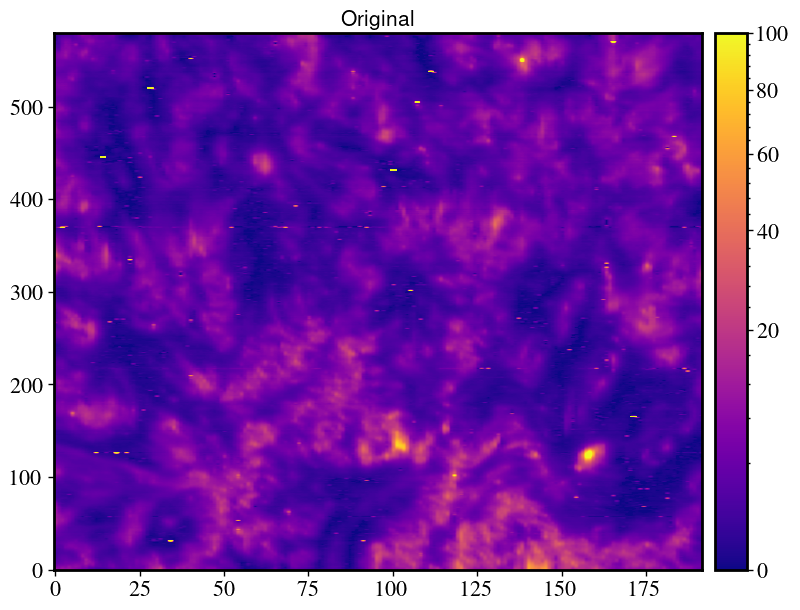

In [16]:
CIII_origin_fitmodel.plot_fit2d(param="int",vmin=0,vmax=100,scale="sqrt",
                                  aspect=1.098/4,cmap="plasma",
                                  title="Original")

Doppler velocity corrected by the median of each raster.


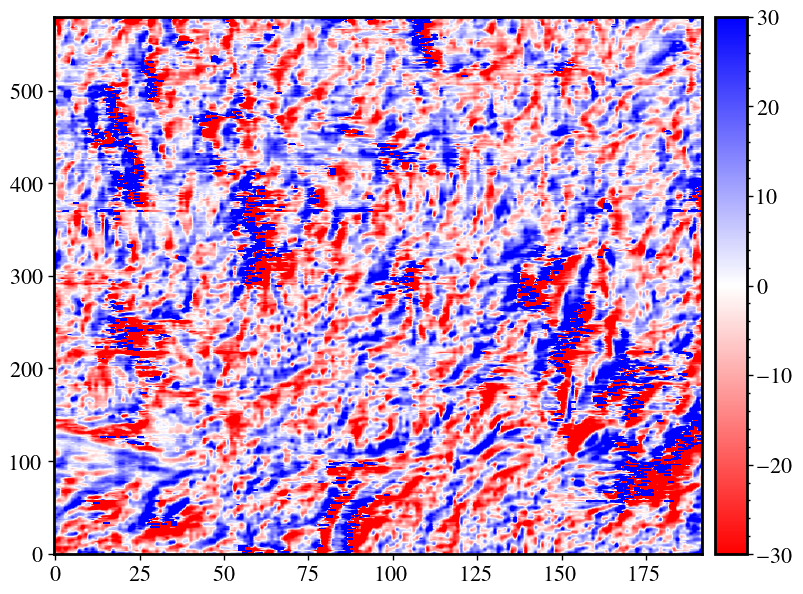

In [19]:
CIII_origin_fitmodel.plot_fit2d(param="vel",vmin=-30,vmax=30,vel_corr="column",ref_wvl=977.020,   
                                    aspect=1.098/4,)
plt.show()

In [21]:
CIII_deconv_rebin_fitmodel = SpectrumFit2D(spice_corr_dat[:,:,4:14].transpose([1,0,2]).astype(np.float32), CIII_977_window_wvl[4:14],
                            line_number=1,line_wvl_init=[977],int_max_init=0.2,fwhm_init=1,
                            same_width=False)
CIII_deconv_rebin_fitmodel.run_lse_mp(prev_init=False,absolute_sigma=False)

/home/yjzhu/SOLAR/MyPy/juanfit.py:291: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(self.multi_gaussian_diff_width, self.wvl_tofit, self.data_tofit,


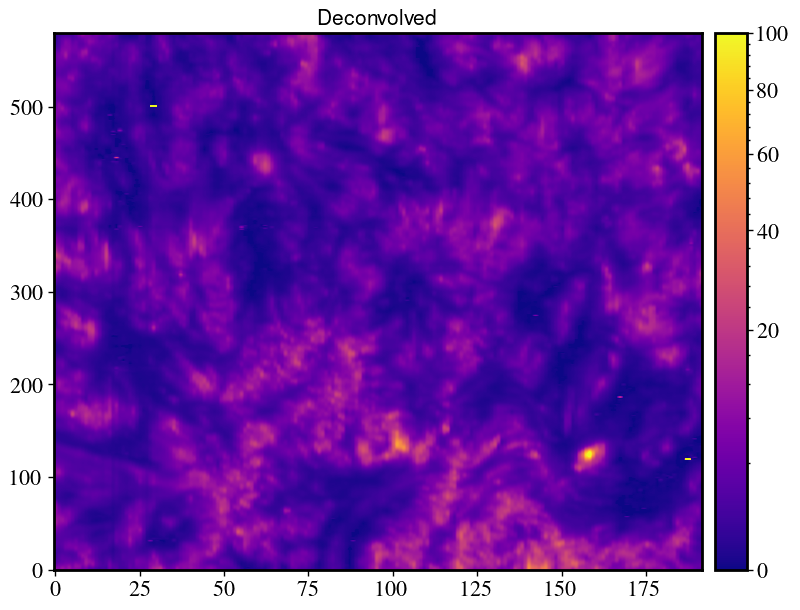

In [22]:
CIII_deconv_rebin_fitmodel.plot_fit2d(param="int",vmin=0,vmax=100,scale="sqrt",
                                    aspect=1.098/4,cmap="plasma",
                                    title="Deconvolved")

Doppler velocity corrected by the median of each raster.


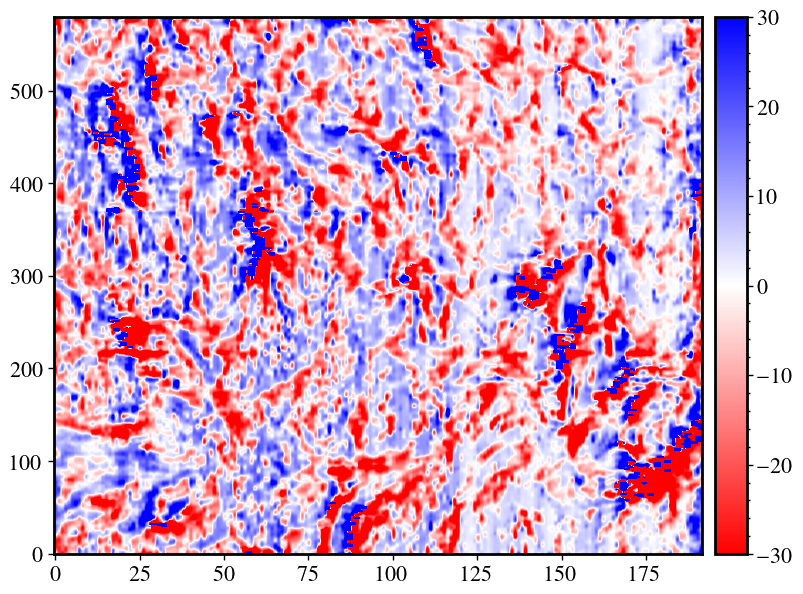

In [25]:
CIII_deconv_rebin_fitmodel.plot_fit2d(param="vel",vmin=-30,vmax=30,vel_corr="column",ref_wvl=977.020,
                                    aspect=1.098/4,)